[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal-7/Challenge_LLM_for_Insurance_Claim_Automation/blob/main/code/Mdl3_pretrained_bert_embeddings_NN.ipynb)

## Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from transformers import DistilBertTokenizer
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
import torch.nn as nn
TF_ENABLE_ONEDNN_OPTS=0

2023-08-03 16:54:35.264736: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
os.getcwd()
# os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI/TRAINING")

'/home/nitesh/Documents/MY_THESIS/MAMI'

In [3]:
def export_classification_report(report, mod, eval_set=None):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    
    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'EvalSet': [eval_set],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
    }) 
    
    return df

# Function to apply text perturbation
def apply_text_perturbation(text):
    words = text.split()  # Split the text into words
    perturbed_words = []
    for word in words:
        # Apply perturbation to each word
        if random.random() < 0.2:  # 20% chance of perturbing a word
            perturbed_word = ""
            for char in word:
                if char in ["a", "e", "i", "o", "u"]:
                    perturbed_char = chr(ord(char) + 32)  # Replace vowel with a space
                else:
                    perturbed_char = char
                perturbed_word += perturbed_char

            perturbed_words.append(perturbed_word)
    perturbed_text = " ".join(perturbed_words)  # Join the perturbed words back into a text
    return perturbed_text

In [4]:
# Load the data
#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


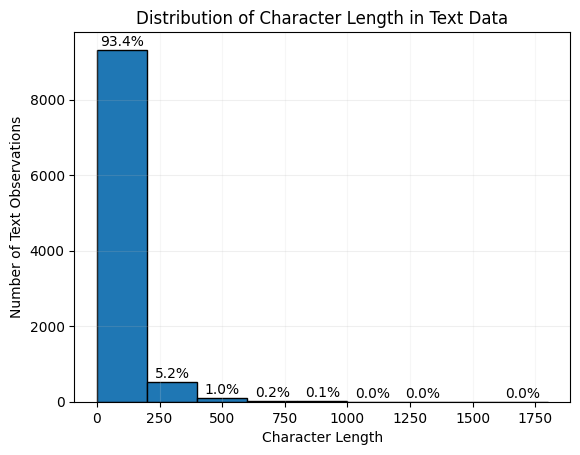

In [5]:
### CHARACTER LENGTH MIN AND MAX ANALYSIS

import matplotlib.pyplot as plt

# Calculate character length for each text and add a new column 'char_length'
trainx['char_length'] = trainx['text'].apply(len)

# Find minimum and maximum character length
min_length = trainx['char_length'].min()
max_length = trainx['char_length'].max()

# Define bin edges for the histogram
bin_edges = [x * 200 for x in range((max_length // 200) + 2)]

# Plot the distribution
fig, ax = plt.subplots()
histogram = ax.hist(trainx['char_length'], bins=bin_edges, edgecolor='black')
plt.xlabel('Character Length')
plt.ylabel('Number of Text Observations')
plt.title('Distribution of Character Length in Text Data')
plt.grid(axis='y', alpha=0.2)  # Set alpha to control grid line opacity
plt.grid(axis='x', color='lightgrey', alpha=0.2)  # Set x-axis grid color and alpha

# Add labels to the bars representing their heights
for val, bin_edge in zip(histogram[0], histogram[1][:-1]):
    if val > 0:
        percentage = val / len(trainx) * 100
        ax.annotate(f'{percentage:.1f}%', xy=(bin_edge + (bin_edges[1] - bin_edges[0]) / 2, val),
                    xytext=(0, 3), textcoords='offset points', ha='center')

plt.show()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 32)           412

2023-08-03 16:57:18.248808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 16:57:18.280961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 16:57:18.281132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 16:57:18.281538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
112/313 [=========>....................] - ETA: 0s - loss: 42.6767 - kl_loss: 1.7943 - mse_loss: 40.8823

2023-08-03 16:57:19.832133: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 25.9488 - kl_loss: 0.8965 - mse_loss: 25.0523
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 16.0745 - kl_loss: 0.2282 - mse_loss: 15.8463
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 15.8947 - kl_loss: 0.1426 - mse_loss: 15.7521
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 15.7592 - kl_loss: 0.0874 - mse_loss: 15.6718
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 15.6306 - kl_loss: 0.0840 - mse_loss: 15.5467
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 15.5418 - kl_loss: 0.0944 - mse_loss: 15.4474
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 15.4861 - kl_loss: 0.1075 - mse_loss: 15.3786
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 15.4425 - kl_loss: 0.1166 - mse_loss: 15.3259
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6640
Epoch 1/20, Validation Loss: 0.6370

Epoch 2/20, Train Loss: 0.6319
Epoch 2/20, Validation Loss: 0.6249

Epoch 3/20, Train Loss: 0.6258
Epoch 3/20, Validation Loss: 0.6229

Epoch 4/20, Train Loss: 0.6212
Epoch 4/20, Validation Loss: 0.6192

Epoch 5/20, Train Loss: 0.6189
Epoch 5/20, Validation Loss: 0.6253

Epoch 6/20, Train Loss: 0.6168
Epoch 6/20, Validation Loss: 0.6222

Epoch 7/20, Train Loss: 0.6138
Epoch 7/20, Validation Loss: 0.6220

Epoch 8/20, Train Loss: 0.6128
Epoch 8/20, Validation Loss: 0.6198

Epoch 9/20, Train Loss: 0.6114
Epoch 9/20, Validation Loss: 0.6179

Epoch 10/20, Train Loss: 0.6090
Epoch 10/20, Validation Loss: 0.6159

Epoch 11/20, Train Loss: 0.6074
Epoch 11/20, Validation Loss: 0.6154

Epoch 12/20, Train Loss: 0.6060
Epoch 12/20, Validation Loss: 0.6140

Epoch 13/20, Train Loss: 0.6042
Epoch 13/20, Validation Loss: 0.6206

Epoch 14/20, Train Loss: 0.6015
Epoch 14/20, Validation Loss: 0.6154

Epoch 15/20, Train Loss: 0.6022
Epoch 

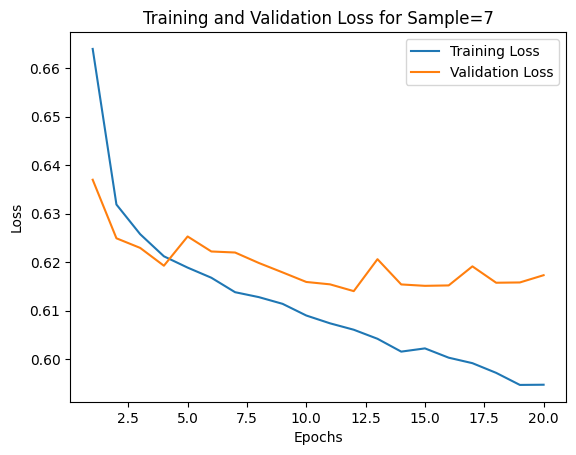

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.647     0.792     0.712      4484
           1      0.734     0.570     0.642      4503

    accuracy                          0.681      8987
   macro avg      0.690     0.681     0.677      8987
weighted avg      0.690     0.681     0.677      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.652     0.749     0.697       506
           1      0.696     0.590     0.639       493

    accuracy                          0.671       999
   macro avg      0.674     0.670     0.668       999
weighted avg      0.674     0.671     0.668       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.659     0.444     0.530       500
           1      0.581     0.770     0.662       500

    accuracy                          0.607      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

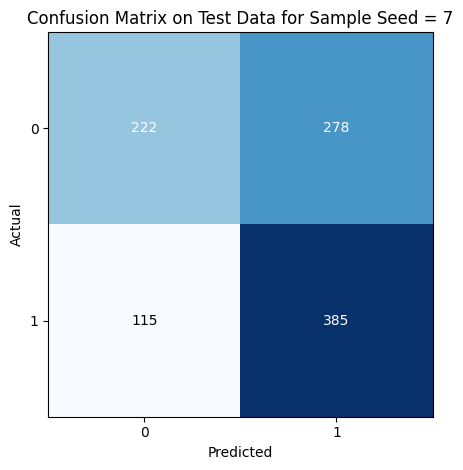

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 32)           412

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6683
Epoch 1/20, Validation Loss: 0.6316

Epoch 2/20, Train Loss: 0.6248
Epoch 2/20, Validation Loss: 0.6162

Epoch 3/20, Train Loss: 0.6143
Epoch 3/20, Validation Loss: 0.6138

Epoch 4/20, Train Loss: 0.6109
Epoch 4/20, Validation Loss: 0.6100

Epoch 5/20, Train Loss: 0.6085
Epoch 5/20, Validation Loss: 0.6113

Epoch 6/20, Train Loss: 0.6032
Epoch 6/20, Validation Loss: 0.6157

Epoch 7/20, Train Loss: 0.6029
Epoch 7/20, Validation Loss: 0.6137

Epoch 8/20, Train Loss: 0.5999
Epoch 8/20, Validation Loss: 0.6142

Epoch 9/20, Train Loss: 0.5977
Epoch 9/20, Validation Loss: 0.6124

Epoch 10/20, Train Loss: 0.5980
Epoch 10/20, Validation Loss: 0.6124

Epoch 11/20, Train Loss: 0.5949
Epoch 11/20, Validation Loss: 0.6113

Epoch 12/20, Train Loss: 0.5940
Epoch 12/20, Validation Loss: 0.6116

Epoch 13/20, Train Loss: 0.5937
Epoch 13/20, Validation Loss: 0.6091

Epoch 14/20, Train Loss: 0.5911
Epoch 14/20, Validation Loss: 0.6132

Epoch 15/20, Train Loss: 0.5888
Epoch 

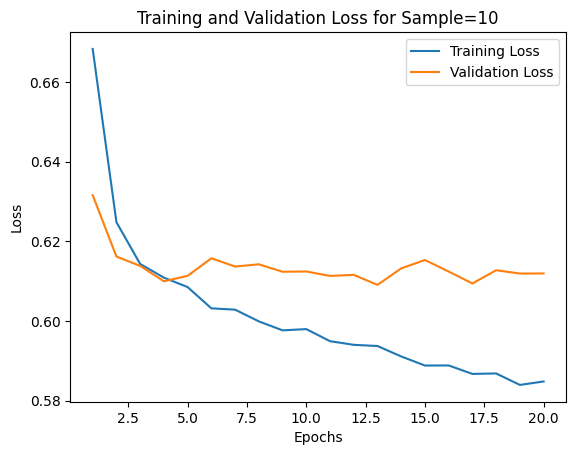

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.658     0.784     0.715      4468
           1      0.736     0.597     0.660      4519

    accuracy                          0.690      8987
   macro avg      0.697     0.691     0.688      8987
weighted avg      0.697     0.690     0.687      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.661     0.751     0.703       522
           1      0.680     0.579     0.625       477

    accuracy                          0.669       999
   macro avg      0.670     0.665     0.664       999
weighted avg      0.670     0.669     0.666       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.669     0.546     0.601       500
           1      0.617     0.730     0.668       500

    accuracy                          0.638      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

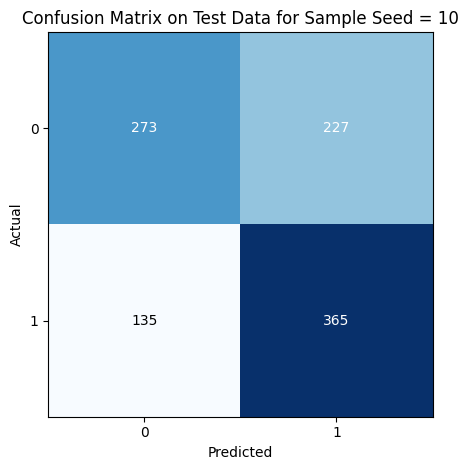

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                                                                  
 dense_11 (Dense)               (None, 32)           412

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6581
Epoch 1/20, Validation Loss: 0.6405

Epoch 2/20, Train Loss: 0.6285
Epoch 2/20, Validation Loss: 0.6324

Epoch 3/20, Train Loss: 0.6231
Epoch 3/20, Validation Loss: 0.6290

Epoch 4/20, Train Loss: 0.6187
Epoch 4/20, Validation Loss: 0.6267

Epoch 5/20, Train Loss: 0.6172
Epoch 5/20, Validation Loss: 0.6274

Epoch 6/20, Train Loss: 0.6157
Epoch 6/20, Validation Loss: 0.6258

Epoch 7/20, Train Loss: 0.6133
Epoch 7/20, Validation Loss: 0.6239

Epoch 8/20, Train Loss: 0.6101
Epoch 8/20, Validation Loss: 0.6262

Epoch 9/20, Train Loss: 0.6097
Epoch 9/20, Validation Loss: 0.6299

Epoch 10/20, Train Loss: 0.6078
Epoch 10/20, Validation Loss: 0.6250

Epoch 11/20, Train Loss: 0.6060
Epoch 11/20, Validation Loss: 0.6252

Epoch 12/20, Train Loss: 0.6052
Epoch 12/20, Validation Loss: 0.6234

Epoch 13/20, Train Loss: 0.6032
Epoch 13/20, Validation Loss: 0.6227

Epoch 14/20, Train Loss: 0.6020
Epoch 14/20, Validation Loss: 0.6248

Epoch 15/20, Train Loss: 0.5988
Epoch 

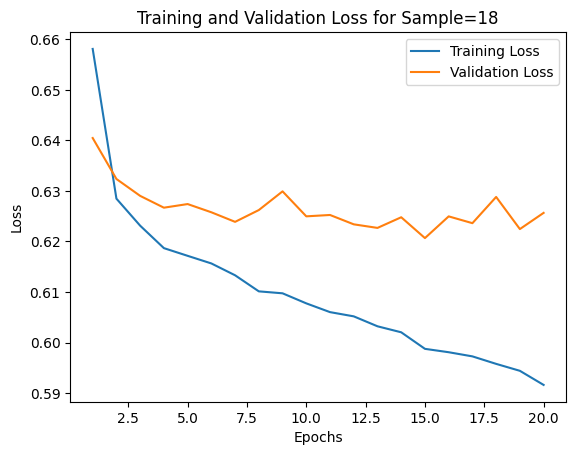

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.655     0.775     0.710      4505
           1      0.723     0.590     0.649      4482

    accuracy                          0.682      8987
   macro avg      0.689     0.682     0.680      8987
weighted avg      0.689     0.682     0.680      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.624     0.748     0.680       485
           1      0.707     0.574     0.634       514

    accuracy                          0.659       999
   macro avg      0.666     0.661     0.657       999
weighted avg      0.667     0.659     0.656       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.644     0.546     0.591       500
           1      0.606     0.698     0.649       500

    accuracy                          0.622      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

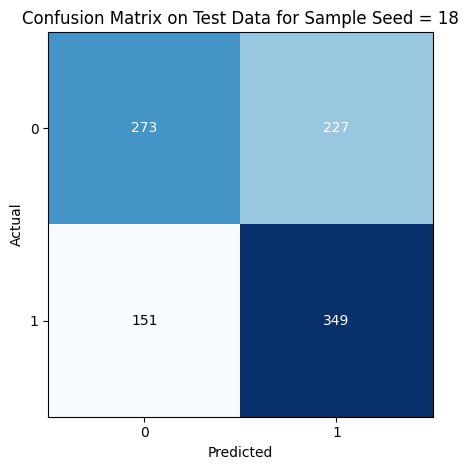

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 32)           412

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 522bc641-628b-4548-9553-c7b957c07dea)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6598
Epoch 1/20, Validation Loss: 0.6460

Epoch 2/20, Train Loss: 0.6272
Epoch 2/20, Validation Loss: 0.6363

Epoch 3/20, Train Loss: 0.6194
Epoch 3/20, Validation Loss: 0.6332

Epoch 4/20, Train Loss: 0.6168
Epoch 4/20, Validation Loss: 0.6286

Epoch 5/20, Train Loss: 0.6133
Epoch 5/20, Validation Loss: 0.6298

Epoch 6/20, Train Loss: 0.6090
Epoch 6/20, Validation Loss: 0.6307

Epoch 7/20, Train Loss: 0.6085
Epoch 7/20, Validation Loss: 0.6267

Epoch 8/20, Train Loss: 0.6067
Epoch 8/20, Validation Loss: 0.6257

Epoch 9/20, Train Loss: 0.6031
Epoch 9/20, Validation Loss: 0.6266

Epoch 10/20, Train Loss: 0.6022
Epoch 10/20, Validation Loss: 0.6253

Epoch 11/20, Train Loss: 0.6015
Epoch 11/20, Validation Loss: 0.6279

Epoch 12/20, Train Loss: 0.5980
Epoch 12/20, Validation Loss: 0.6265

Epoch 13/20, Train Loss: 0.5981
Epoch 13/20, Validation Loss: 0.6271

Epoch 14/20, Train Loss: 0.5954
Epoch 14/20, Validation Loss: 0.6259

Epoch 15/20, Train Loss: 0.5933
Epoch 

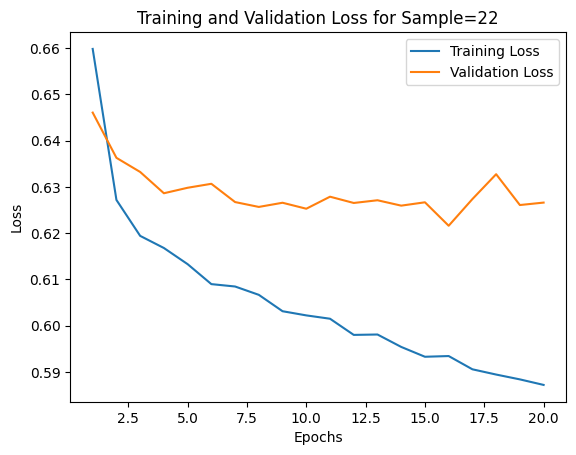

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.650     0.789     0.713      4492
           1      0.732     0.575     0.644      4495

    accuracy                          0.682      8987
   macro avg      0.691     0.682     0.678      8987
weighted avg      0.691     0.682     0.678      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.624     0.739     0.676       498
           1      0.682     0.557     0.613       501

    accuracy                          0.648       999
   macro avg      0.653     0.648     0.645       999
weighted avg      0.653     0.648     0.645       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.628     0.698     0.661       500
           1      0.660     0.586     0.621       500

    accuracy                          0.642      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

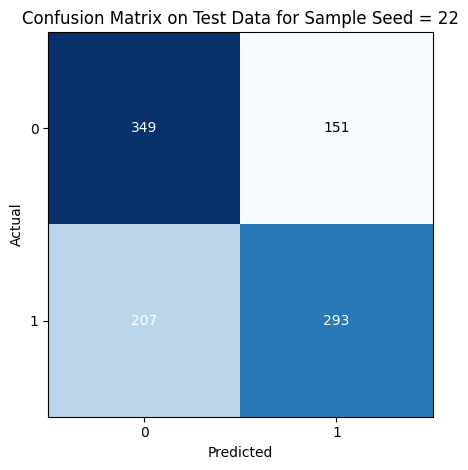

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 32)           412

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6577
Epoch 1/20, Validation Loss: 0.6277

Epoch 2/20, Train Loss: 0.6284
Epoch 2/20, Validation Loss: 0.6155

Epoch 3/20, Train Loss: 0.6213
Epoch 3/20, Validation Loss: 0.6146

Epoch 4/20, Train Loss: 0.6193
Epoch 4/20, Validation Loss: 0.6122

Epoch 5/20, Train Loss: 0.6156
Epoch 5/20, Validation Loss: 0.6098

Epoch 6/20, Train Loss: 0.6125
Epoch 6/20, Validation Loss: 0.6117

Epoch 7/20, Train Loss: 0.6119
Epoch 7/20, Validation Loss: 0.6083

Epoch 8/20, Train Loss: 0.6099
Epoch 8/20, Validation Loss: 0.6080

Epoch 9/20, Train Loss: 0.6080
Epoch 9/20, Validation Loss: 0.6103

Epoch 10/20, Train Loss: 0.6089
Epoch 10/20, Validation Loss: 0.6087

Epoch 11/20, Train Loss: 0.6037
Epoch 11/20, Validation Loss: 0.6087

Epoch 12/20, Train Loss: 0.6030
Epoch 12/20, Validation Loss: 0.6087

Epoch 13/20, Train Loss: 0.6016
Epoch 13/20, Validation Loss: 0.6032

Epoch 14/20, Train Loss: 0.6020
Epoch 14/20, Validation Loss: 0.6077

Epoch 15/20, Train Loss: 0.5989
Epoch 

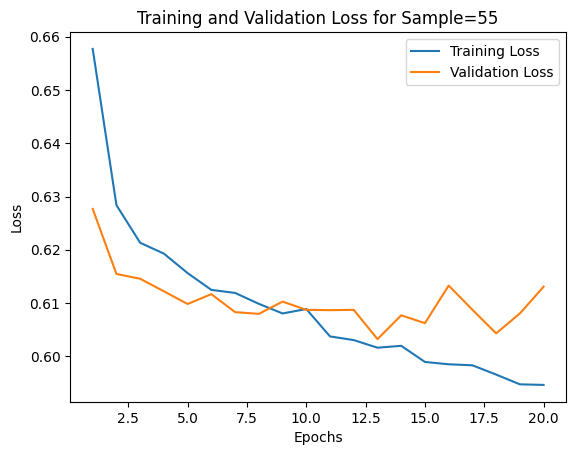

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.793     0.718      4494
           1      0.738     0.585     0.653      4493

    accuracy                          0.689      8987
   macro avg      0.697     0.689     0.685      8987
weighted avg      0.697     0.689     0.685      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.637     0.752     0.689       496
           1      0.702     0.577     0.633       503

    accuracy                          0.664       999
   macro avg      0.669     0.664     0.661       999
weighted avg      0.670     0.664     0.661       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.654     0.476     0.551       500
           1      0.588     0.748     0.658       500

    accuracy                          0.612      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

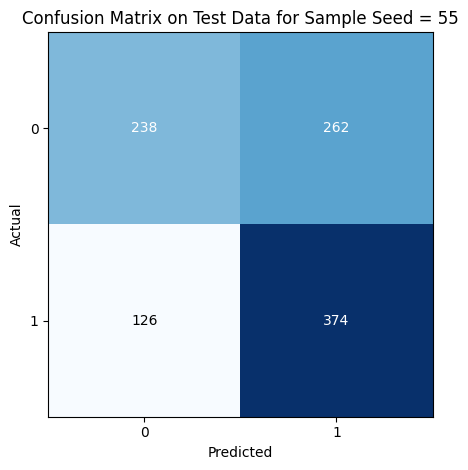

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
10986 10986
9986 1000
torch.Size([9986, 768]) torch.Size([1000, 768])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 768)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          98432       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                                                                  
 dense_26 (Dense)               (None, 32)           412

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_34758/875942990.py:418: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/20, Train Loss: 0.6598
Epoch 1/20, Validation Loss: 0.6330

Epoch 2/20, Train Loss: 0.6219
Epoch 2/20, Validation Loss: 0.6189

Epoch 3/20, Train Loss: 0.6149
Epoch 3/20, Validation Loss: 0.6169

Epoch 4/20, Train Loss: 0.6098
Epoch 4/20, Validation Loss: 0.6140

Epoch 5/20, Train Loss: 0.6078
Epoch 5/20, Validation Loss: 0.6094

Epoch 6/20, Train Loss: 0.6037
Epoch 6/20, Validation Loss: 0.6128

Epoch 7/20, Train Loss: 0.6025
Epoch 7/20, Validation Loss: 0.6166

Epoch 8/20, Train Loss: 0.5999
Epoch 8/20, Validation Loss: 0.6115

Epoch 9/20, Train Loss: 0.5986
Epoch 9/20, Validation Loss: 0.6131

Epoch 10/20, Train Loss: 0.5968
Epoch 10/20, Validation Loss: 0.6069

Epoch 11/20, Train Loss: 0.5944
Epoch 11/20, Validation Loss: 0.6099

Epoch 12/20, Train Loss: 0.5923
Epoch 12/20, Validation Loss: 0.6110

Epoch 13/20, Train Loss: 0.5918
Epoch 13/20, Validation Loss: 0.6081

Epoch 14/20, Train Loss: 0.5916
Epoch 14/20, Validation Loss: 0.6108

Epoch 15/20, Train Loss: 0.5896
Epoch 

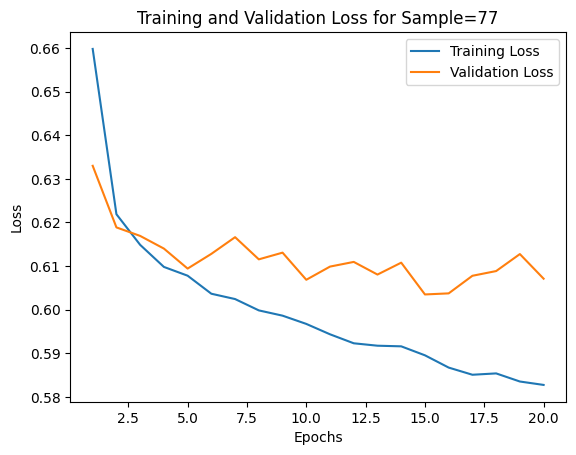

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.657     0.796     0.720      4522
           1      0.737     0.579     0.648      4465

    accuracy                          0.688      8987
   macro avg      0.697     0.687     0.684      8987
weighted avg      0.697     0.688     0.684      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.608     0.765     0.677       468
           1      0.732     0.565     0.638       531

    accuracy                          0.659       999
   macro avg      0.670     0.665     0.658       999
weighted avg      0.674     0.659     0.656       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.664     0.612     0.637       500
           1      0.640     0.690     0.664       500

    accuracy                          0.651      1000
   macro avg      0

/tmp/ipykernel_34758/875942990.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_34758/875942990.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_pt).

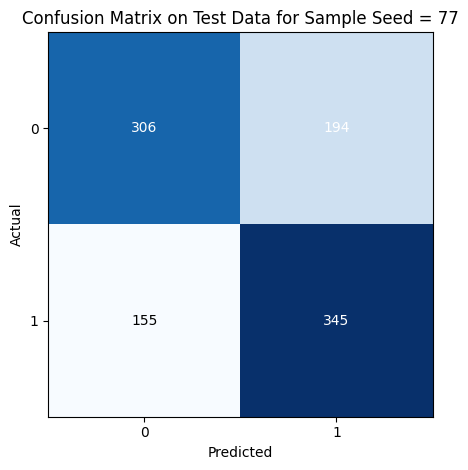

In [6]:
PERFORMANCE_RESULTS = pd.DataFrame(columns=['Model', 'EvalSet', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score'])

mse_val1 = []
KL_LOSS1 = []

for KK in list([7,10,18,22,55,77]): 

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    #     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 32)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].apply(apply_text_perturbation).tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)


    import os
    import pickle

    os.chdir('/home/nitesh/Documents/MY_THESIS/MAMI')
    # Folder path
    folder_path = "18_ViTEmbeddings"

    # Function to get all pickle files that start with "enb_" and sort them in ascending order
    def get_sorted_enb_pickles(folder_path):
        enb_pickles = []
        for filename in os.listdir(folder_path):
            if filename.startswith("emb_") and filename.endswith(".pickle"):
                enb_pickles.append(filename)
        enb_pickles.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
        return [os.path.join(folder_path, filename) for filename in enb_pickles]


    # Function to load embeddings from a pickle file
    def load_embeddings_from_pickle(file_path):
        with open(file_path, "rb") as file:
            embeddings = pickle.load(file)
        return embeddings
    # Get all pickle files that start with "enb_" and sort them
    emb_pickle_files = get_sorted_enb_pickles(folder_path)

    all_embeddings_list = []

    # Load and process all pickle files
    for pklfile in emb_pickle_files:
        try:
            embeddings_list = load_embeddings_from_pickle(pklfile)
            # Process the embeddings_list here as per your requirement
            all_embeddings_list.extend(embeddings_list)
        except Exception as e:
            print(f"Error loading embeddings from {pklfile}: {e}")



    # Function to get all pickle files that start with "enb_" and sort them in ascending order
    def get_sorted_labels_pickles(folder_path):
        enb_pickles = []
        for filename in os.listdir(folder_path):
            if filename.startswith("label_") and filename.endswith(".pickle"):
                enb_pickles.append(filename)
        enb_pickles.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
        return [os.path.join(folder_path, filename) for filename in enb_pickles]

    # Get all pickle files that start with "enb_" and sort them
    labels_pickle_files = get_sorted_labels_pickles(folder_path)

    all_labels_list = []

    # Load and process all pickle files
    for pklfile in labels_pickle_files:
        try:
            labels_list = load_embeddings_from_pickle(pklfile)
            # Process the embeddings_list here as per your requirement
            all_labels_list.extend(labels_list)
        except Exception as e:
            print(f"Error loading embeddings from {pklfile}: {e}")

    print(len(all_embeddings_list), len(all_labels_list))

    all_image_features_16 = all_embeddings_list[:-1000]
    clip_test_embeddings = all_embeddings_list[-1000:]

    print(len(all_image_features_16), len(clip_test_embeddings))



    all_image_features_16 = all_embeddings_list[:-1000]
    all_image_features_16 = torch.stack(all_image_features_16)
    all_image_features_16.shape


    clip_test_embeddings = all_embeddings_list[-1000:]
    clip_test_embeddings = torch.stack(clip_test_embeddings)
    clip_test_embeddings.shape

    print(all_image_features_16.shape, clip_test_embeddings.shape)



    #################3 VAE MODEL on VIT EMBEDDINGS ###########################
    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 32
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.detach().numpy()


    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 32

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")

    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 


    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 




    ################ TEST EMBEDDINGS FROM VAE ENCODER #######################
    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.detach().numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)

    os.chdir('/home/nitesh/Documents/MY_THESIS/MAMI')

    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')


    ###########################################################

    # Apply text perturbation to the training captions
    train_capn["text"] = train_capn["text"].apply(apply_text_perturbation)


    ############################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 32)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), 
                                            axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    from sklearn.model_selection import train_test_split
    device='cpu'
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1}).to_list()
    # train_labels= train_lbls

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1}).to_list()
    # test_labels= test_lbls


    seed_value = KK
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    fusion_embeddings_train_pt = torch.tensor(fusion_embeddings_train).to(device)
    fusion_embeddings_test_pt = torch.tensor(fusion_embeddings_test).to(device)

    train_labels_pt = torch.tensor(train_lbls).to(device)
    test_labels_pt = torch.tensor(test_lbls).to(device)


    # Split the data into train and validation sets
    train_embeddings1, val_embeddings1, train_labels1, val_labels1 = train_test_split(fusion_embeddings_train_pt, 
                                                                                      train_labels_pt, 
                                                                                      test_size=0.1, 
                                                                                      random_state=KK)

    print("train data shape: ", train_embeddings1.shape, "validation data shape: ", val_embeddings1.shape,
         'test embd shape:', fusion_embeddings_test.shape)


    # Define the multiclass classification model
    class MulticlassClassifier(nn.Module):
        def __init__(self, input_size, num_classes):
            super(MulticlassClassifier, self).__init__()
            self.fc1 = nn.Linear(input_size, 128)
            self.fc2 = nn.Linear(128, num_classes)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.dropout(out)
            out = self.fc2(out)
            return out

    import torch.optim as optim

    model_NN = MulticlassClassifier(input_size=train_embeddings1.shape[1], 
                                    num_classes=len(set(train_lbls)))

    model_NN = model_NN.to(device)  # Move model to CUDA GPU
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    num_epochs = 20
    batch_size = 16

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
            epoch_loss = 0.0

            for i in range(0, len(train_embeddings1), batch_size):
                batch_embeddings = train_embeddings1[i:i+batch_size].requires_grad_(True).to(device)  # Move tensor to CUDA GPU
                batch_labels = train_labels1[i:i+batch_size]
                batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU

                # Forward pass
                train_outputs = model_NN(batch_embeddings)
                loss = criterion(train_outputs, batch_labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()  # Accumulate the loss

            avg_train_loss = epoch_loss / (len(train_embeddings1) // batch_size)  # Calculate average training loss
            train_losses.append(avg_train_loss)

                    # Evaluate the model on the validation set
            with torch.no_grad():
                val_embeddings2 = val_embeddings1.to(device)
                val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()
                val_outputs = model_NN(val_embeddings2)
                val_loss = criterion(val_outputs, val_labels2)

            val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}")
            print()

            # Plotting the loss curves
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Sample={KK}')
    plt.legend()
    plt.show()


    modname  = 'DistilBERT_ViT_BLIP_NN_VOWELPERTURB'

    # Evaluate the model on training set
    model_NN.eval()
    with torch.no_grad():
        train_emb = train_embeddings1.to(device)  # Move tensor to CUDA GPU
        train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
        train_otpt = model_NN(train_emb)


    # Convert the predicted values and original test labels to CPU
    train_preds = train_otpt.to('cpu').argmax(dim=1).numpy()
    train_labelsx=np.array(train_labels1)

    # Generate classification report
    print("Training Data Classification Report:")
    eval_set='training'
    classification_rep_train = classification_report(train_labelsx, train_preds, digits=3)
    print(classification_rep_train)

    results_train= export_classification_report(classification_rep_train, modname, eval_set='training')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_train])






    # Evaluate the model on validation set
    model_NN.eval()
    with torch.no_grad():
        val_emb = val_embeddings1.to(device)  # Move tensor to CUDA GPU
        val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
        val_otpt = model_NN(val_emb)
    #     test_loss = criterion(val_otpt, val_lbls)    

    # Convert the predicted values and original test labels to CPU
    val_preds = val_otpt.to('cpu').argmax(dim=1).numpy()
    val_labelsx=np.array(val_labels1)

    print("Validation Data Classification Report:")
    eval_set='validation'
    classification_rep_val = classification_report(val_labelsx, val_preds, digits=3)
    print(classification_rep_val)
    results_val= export_classification_report(classification_rep_val, modname, eval_set='validation')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_val])





    # Evaluate the model on test set
    model_NN.eval()
    with torch.no_grad():
        test_embeddings = fusion_embeddings_test_pt.to(device)  # Move tensor to CUDA GPU
        test_labels = torch.tensor(test_labels_pt).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
        test_outputs = model_NN(test_embeddings)
        test_loss = criterion(test_outputs, test_labels)

    # Convert the predicted values and original test labels to CPU
    test_preds = test_outputs.to('cpu').argmax(dim=1).numpy()
    test_labels = test_labels.to('cpu').numpy()

    print("Test Data Classification Report:")
    classification_rep_test = classification_report(test_labels, test_preds, digits=3)
    print(classification_rep_test)
    results_test= export_classification_report(classification_rep_test, modname, eval_set='test')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_test])

    class_labels = [0,1]
    class_labels1 = ['non_misogyn', 'misogyn']
    confusion_mat = confusion_matrix(test_labels, test_preds, labels=class_labels)
    print("Confusion Matrix:")
    # print(confusion_mat)
    confusion_df = pd.DataFrame(confusion_mat, index=class_labels1, columns=class_labels1)
    print(confusion_df)
    # Plot the confusion matrix with filled colors
    plt.imshow(confusion_mat, cmap='Blues', interpolation='nearest')

    # Add labels and title
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=0)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on Test Data for Sample Seed = {KK}')

    # Add text annotations in each cell
    thresh = confusion_mat.max() / 2
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            plt.text(j, i, format(confusion_mat[i, j], 'd'), ha="center", va="center",
                     color="white" if confusion_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    del class_labels, class_labels1, train_emb, test_embeddings, train_embeddings1, val_emb 

In [16]:
# # (469+270)/(270+230+31+469)
# tn, fp, fn, tp = confusion_matrix(test_labels, test_preds,labels=class_labels).ravel()

# pr = tp/(tp+fp)
# print(pr)
# rcl = tp/(tp+fn)
# print(rcl)
# os.getcwd()
PERFORMANCE_RESULTS


,Model,EvalSet,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,training,0.681,0.690,0.681,0.677,0.690,0.681,0.677
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,validation,0.671,0.674,0.670,0.668,0.674,0.671,0.668
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.607,0.620,0.607,0.596,0.620,0.607,0.596
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,training,0.690,0.697,0.691,0.688,0.697,0.690,0.687
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,validation,0.669,0.670,0.665,0.664,0.670,0.669,0.666
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.638,0.643,0.638,0.635,0.643,0.638,0.635
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,training,0.682,0.689,0.682,0.680,0.689,0.682,0.680
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,validation,0.659,0.666,0.661,0.657,0.667,0.659,0.656
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.622,0.625,0.622,0.620,0.625,0.622,0.620
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,training,0.682,0.691,0.682,0.678,0.691,0.682,0.678


In [17]:
# Filter the DataFrame based on the 'CATEGORY' column
PERFORMANCE_RESULTS1 = PERFORMANCE_RESULTS[PERFORMANCE_RESULTS['EvalSet'] == 'test']

# Print the filtered DataFrame
display(PERFORMANCE_RESULTS1)

,Model,EvalSet,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.607,0.620,0.607,0.596,0.620,0.607,0.596
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.638,0.643,0.638,0.635,0.643,0.638,0.635
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.622,0.625,0.622,0.620,0.625,0.622,0.620
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.642,0.644,0.642,0.641,0.644,0.642,0.641
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.612,0.621,0.612,0.605,0.621,0.612,0.605
0,DistilBERT_ViT_BLIP_NN_VOWELPERTURB,test,0.651,0.652,0.651,0.650,0.652,0.651,0.650


In [18]:
np.average(PERFORMANCE_RESULTS1['M-F1-Score'])

0.6244999999999999

In [11]:
PERFORMANCE_RESULTS1.to_excel('../../MAMI/18_classification_report_DistilBERT_ViT_BLIP_NN_VOWELPERTURB.xlsx', 
                      index=False)

## Variational Autoencoder MSE Plots 

In [12]:
# os.getcwd()
num_lists = len(mse_val1)  # Number of lists
epochs_vae = range(1, 11)  # Epochs (assuming 10 epochs)


# Plot each list in mse_val1
for i, j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs_vae, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title(f'MSE Value vs. Epochs for Bootstrap Sample Seed={j}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots_VAE/'
    plt.savefig(plot_path + f'13_VAE_TrainingLoss_Epoch_Plot_VOWELPERTURB{j}.png')
    plt.legend()
    plt.show()
    plt.close()  # Close the connection 

In [13]:
# References:

https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/

https://deepchecks.com/a-comprehensive-guide-into-shap-shapley-additive-explanations-values/

https://medium.com/data-science-in-your-pocket/shap-for-interpreting-ml-models-explained-with-codes-e94baf5a204e